# Notebook for `nowcast` results

Before running this notebook, download the pretrained models as described in the `README`


In [1]:
import os
os.environ["HDF5_USE_FILE_LOCKING"]='FALSE'
import sys
sys.path.append('/content/drive/MyDrive/neurips-2020-sevir/src')
import h5py
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import pandas as pd
#from display.display import get_cmap

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
module_path = '/content/drive/MyDrive/neurips-2020-sevir/src'
sys.path.insert(0,module_path)

In [4]:
from display.display import get_cmap

In [5]:
if not os.path.exists('/content/export'):
  os.makedirs('/content/export')

## Load pretrained models

In [6]:
# Load pretrained nowcasting models
# mse_file  = '/content/drive/MyDrive/neurips-2020-sevir/models/nowcast/mse_model.h5'
# mse_model = tf.keras.models.load_model(mse_file,compile=False,custom_objects={"tf": tf})

# style_file = '/content/drive/MyDrive/neurips-2020-sevir/models/nowcast/style_model.h5'
# style_model = tf.keras.models.load_model(style_file,compile=False,custom_objects={"tf": tf})

# mse_style_file = '/content/drive/MyDrive/neurips-2020-sevir/models/nowcast/mse_and_style.h5'
# mse_style_model = tf.keras.models.load_model(mse_style_file,compile=False,custom_objects={"tf": tf})

gan_file = '/content/drive/MyDrive/neurips-2020-sevir/models/nowcast/gan_generator.h5'
gan_model = tf.keras.models.load_model(gan_file,compile=False,custom_objects={"tf": tf})

## Load sample test data

To download sample test data, go to https://www.dropbox.com/s/27pqogywg75as5f/nowcast_testing.h5?dl=0
 and save file to `data/sample/nowcast_testing.h5`


In [7]:
# Load a part of the test dataset
from readers.nowcast_reader import read_data
x_test,y_test = read_data('/content/drive/MyDrive/neurips-2020-sevir/data/interim/nowcast_testing.h5',end=50)

## Plot samples for test set

In [8]:
## 
# Functions for plotting results
##

norm = {'scale':47.54,'shift':33.44}
hmf_colors = np.array( [
    [82,82,82], 
    [252,141,89],
    [255,255,191],
    [145,191,219]
])/255

# Model that implements persistence forecast that just repeasts last frame of input
class persistence:
    def predict(self,x_test):
        return np.tile(x_test[:,:,:,-1:],[1,1,1,12])

def plot_hit_miss_fa(ax,y_true,y_pred,thres):
    mask = np.zeros_like(y_true)
    mask[np.logical_and(y_true>=thres,y_pred>=thres)]=4
    mask[np.logical_and(y_true>=thres,y_pred<thres)]=3
    mask[np.logical_and(y_true<thres,y_pred>=thres)]=2
    mask[np.logical_and(y_true<thres,y_pred<thres)]=1
    cmap=ListedColormap(hmf_colors)
    ax.imshow(mask,cmap=cmap)


def visualize_result(models,x_test,y_test,idx,ax,labels, save_path='/content/image.png'):
    fs=12
    cmap_dict = lambda s: {'cmap':get_cmap(s,encoded=True)[0],
                           'norm':get_cmap(s,encoded=True)[1],
                           'vmin':get_cmap(s,encoded=True)[2],
                           'vmax':get_cmap(s,encoded=True)[3]}
    for i in range(0,13):
        xt = x_test[idx,:,:,i]*norm['scale']+norm['shift']
        
        ax[(i-1)][0].imshow(xt,**cmap_dict('vil'))
    ax[0][0].set_title('Inputs',fontsize=fs)
    
    pers = persistence().predict(x_test[idx:idx+1])
    pers = pers*norm['scale']+norm['shift']
    x_test = x_test[idx:idx+1]
    y_test = y_test[idx:idx+1]*norm['scale']+norm['shift']
    y_preds=[]
    for i,m in enumerate(models):
        yp = m.predict(x_test)
        if isinstance(yp,(list,)):
            yp=yp[0]
        y_preds.append(yp*norm['scale']+norm['shift'])
    
    for i in range(0,12):
        ax[i][1].imshow(y_test[0,:,:,i],**cmap_dict('vil'))
    ax[0][1].set_title('Outputs',fontsize=fs)
        
    for j in range(len(ax)):
        for i in range(len(ax[j])):
            ax[j][i].xaxis.set_ticks([])
            ax[j][i].yaxis.set_ticks([])


    ax[0][0].set_ylabel('-60 Minutes', fontsize=8)
    ax[1][0].set_ylabel('-55 Minutes', fontsize=8)
    ax[2][0].set_ylabel('-50 Minutes', fontsize=8)
    ax[3][0].set_ylabel('-45 Minutes', fontsize=8)
    ax[4][0].set_ylabel('-40 Minutes', fontsize=8)
    ax[5][0].set_ylabel('-35 Minutes', fontsize=8)
    ax[6][0].set_ylabel('-30 Minutes', fontsize=8)
    ax[7][0].set_ylabel('-25 Minutes', fontsize=8)
    ax[8][0].set_ylabel('-20 Minutes', fontsize=8)
    ax[9][0].set_ylabel('-15 Minutes', fontsize=8)
    ax[10][0].set_ylabel('-10 Minutes', fontsize=8)
    ax[11][0].set_ylabel('-5 Minutes', fontsize=8)
    ax[12][0].set_ylabel('0 Minutes', fontsize=8)

    ax[0][1].set_ylabel('+5 Minutes', fontsize=8)
    ax[1][1].set_ylabel('+10 Minutes', fontsize=8)
    ax[2][1].set_ylabel('+15 Minutes', fontsize=8)
    ax[3][1].set_ylabel('+20 Minutes', fontsize=8)
    ax[4][1].set_ylabel('+25 Minutes', fontsize=8)
    ax[5][1].set_ylabel('+30 Minutes', fontsize=8)
    ax[6][1].set_ylabel('+35 Minutes', fontsize=8)
    ax[7][1].set_ylabel('+40 Minutes', fontsize=8)
    ax[8][1].set_ylabel('+45 Minutes', fontsize=8)
    ax[9][1].set_ylabel('+50 Minutes', fontsize=8)
    ax[10][1].set_ylabel('+55 Minutes', fontsize=8)
    ax[11][1].set_ylabel('+60 Minutes', fontsize=8)
    
    
    plt.subplots_adjust(hspace=0.05, wspace=0.05)

    plt.savefig(save_path)
    

### Plot a few test cases

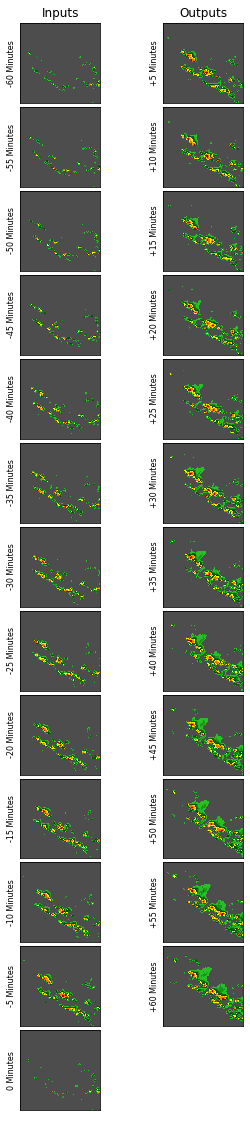

In [9]:
idx=25
fig,ax = plt.subplots(13,2,figsize=(5,20))
fig.delaxes(ax[12][1])
visualize_result([gan_model],x_test,y_test,idx,ax,labels=['cGAN+MAE'])

In [10]:
!pip install fastapi nest-asyncio pyngrok uvicorn

     |████████████████████████████████| 54 kB 2.1 MB/s 
     |████████████████████████████████| 745 kB 10.5 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 58 kB 5.6 MB/s 
     |████████████████████████████████| 10.9 MB 38.2 MB/s 
     |████████████████████████████████| 79 kB 7.9 MB/s 
     |████████████████████████████████| 58 kB 5.5 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=37fa9ebd9d532af3b6dce45f8190a8b36f4bb9f325e89d3241868ee5b151d112
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


In [11]:
from fastapi import FastAPI
from fastapi.responses import Response
from fastapi.middleware.cors import CORSMiddleware
import nest_asyncio
from pyngrok import ngrok
import uvicorn
from datetime import datetime
import os
import traceback
import base64
from fastapi import FastAPI, Request

In [12]:
from datetime import datetime
int(datetime.now().timestamp())

1648216398

Public URL: http://14ac-35-239-178-148.ngrok.io


INFO:     Started server process [278]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     2601:197:601:9520:28bf:bd1e:1c38:dfd:0 - "GET /events?idx_id=33 HTTP/1.1" 404 Not Found
INFO:     2601:197:601:9520:28bf:bd1e:1c38:dfd:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     2601:197:601:9520:28bf:bd1e:1c38:dfd:0 - "GET /events?idx_id=33 HTTP/1.1" 404 Not Found
INFO:     2601:197:601:9520:28bf:bd1e:1c38:dfd:0 - "GET /events?idx_id=33 HTTP/1.1" 404 Not Found
INFO:     34.127.0.121:0 - "GET /event?idx_id=43 HTTP/1.1" 200 OK
INFO:     34.127.0.121:0 - "GET /event?idx_id=44 HTTP/1.1" 200 OK
INFO:     2601:197:601:9520:28bf:bd1e:1c38:dfd:0 - "GET /event?idx_id=25 HTTP/1.1" 200 OK
INFO:     2601:197:601:9520:28bf:bd1e:1c38:dfd:0 - "GET /event?idx_id=30 HTTP/1.1" 200 OK
INFO:     2601:197:601:9520:28bf:bd1e:1c38:dfd:0 - "GET /event?idx_id=41 HTTP/1.1" 200 OK
INFO:     2601:197:601:9520:28bf:bd1e:1c38:dfd:0 - "GET /event?idx_id=15 HTTP/1.1" 200 OK
INFO:     35.230.58.211:0 - "GET /event?idx_id=32 HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [278]


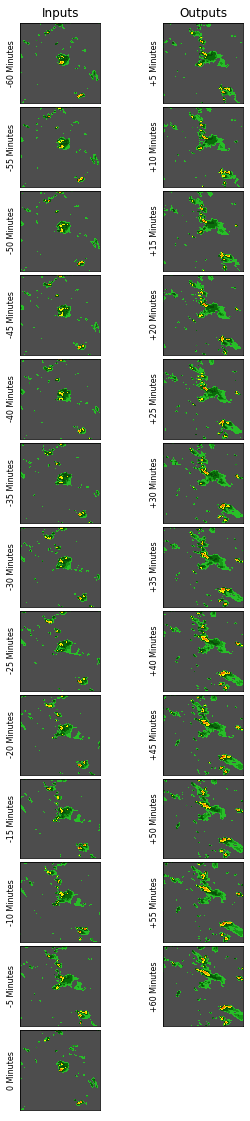

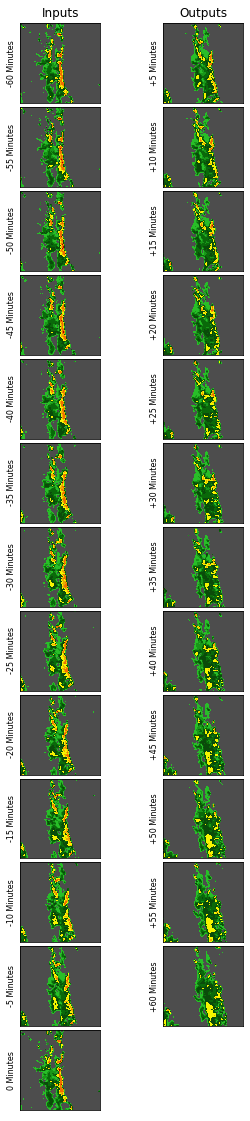

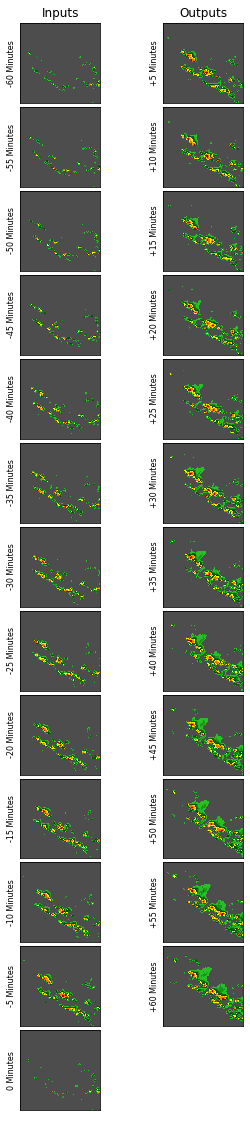

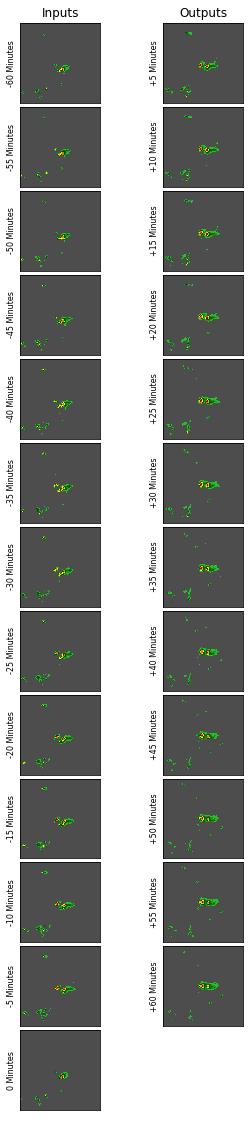

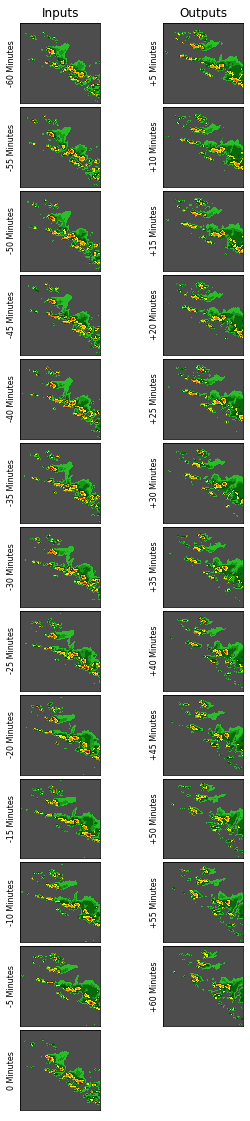

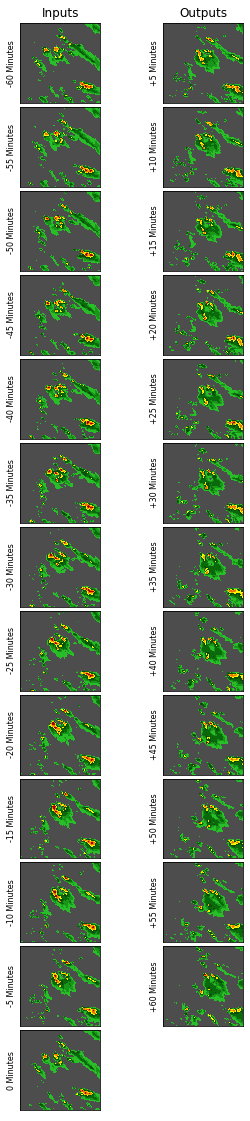

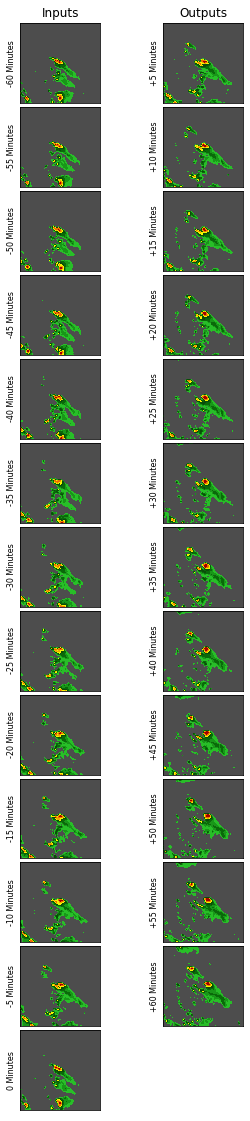

In [13]:
app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=['*'],
    allow_credentials=True,
    allow_methods=['*'],
    allow_headers=['*'],
)

@app.get('/event')
def event_query(request: Request, idx_id: str = ""):
  
  file_name = f"image_{int(datetime.now().timestamp())}.png"
  save_path = "/content/export/"
  file_path = os.path.join(save_path, file_name)
  try:
    fig,ax = plt.subplots(13,2,figsize=(5,20))
    fig.delaxes(ax[12][1])
    visualize_result([gan_model],x_test,y_test,int(idx_id),ax,labels=['cGAN+MAE'],save_path=file_path)
    with open(file_path, "rb") as file:
        image_bytes: bytes = base64.b64encode(file.read())
    return {"data": image_bytes}
  except Exception as e:
    message = traceback.format_exc()
    print(message)
    return "An internal error occurred"

ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)